# Andrea Ambrosini - Segmentation 

## Import libriries 

In [1]:
import cv2 as cv
import spectral as spec
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.ndimage import binary_dilation, binary_opening
import cv2

## Import Images

In [2]:
# Find the specim files
search_dir = "./"
# Get a list of all .hdr files in the directory and its subdirectories
HS_files = glob.glob(os.path.join(search_dir, "**", "*.[hH][dD][rR]"), recursive=True)

HS_res_files = []
for f in HS_files:
    if "results" in f:
        try:
            # Try to open with just the header file
            img = spec.envi.open(f)
            HS_res_files.append(img)
        except spec.io.envi.EnviDataFileNotFoundError:
            # If that fails, try to find the data file
            base_name = os.path.splitext(f)[0]
            # Look for common data file extensions
            for ext in ['.dat', '.img', '.bin', '.raw']:
                data_file = base_name + ext
                if os.path.exists(data_file):
                    try:
                        img = spec.envi.open(f, image=data_file)
                        HS_res_files.append(img)
                        break
                    except:
                        continue

# Print loaded files
print("Found {} reflectance files, first 3:".format(len(HS_res_files)))
for f in HS_res_files[:3]:
    print(f)

Found 27 reflectance files, first 3:
	Data Source:   '././Photos/Sukkari/345/results/REFLECTANCE_345.dat'
	# Rows:            512
	# Samples:         512
	# Bands:           204
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32
	Data Source:   '././Photos/Sukkari/346/results/REFLECTANCE_346.dat'
	# Rows:            512
	# Samples:         512
	# Bands:           204
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32
	Data Source:   '././Photos/Sukkari/347/results/REFLECTANCE_347.dat'
	# Rows:            512
	# Samples:         512
	# Bands:           204
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32


## Plotting data

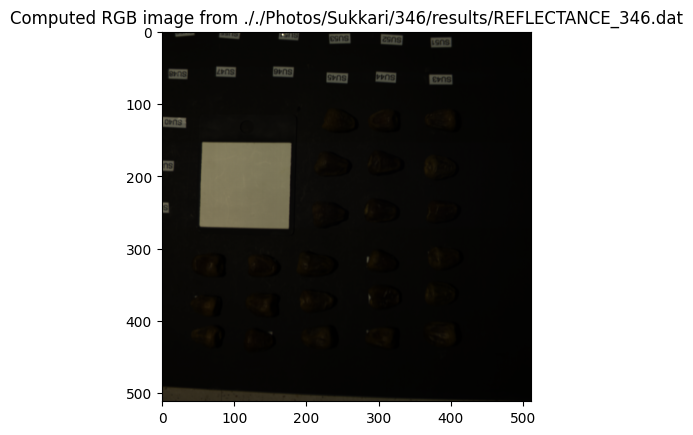

In [3]:
wave = np.linspace(400, 1000, 204)
example_HS = HS_res_files[1]
plt.figure()
plt.imshow(spec.get_rgb(example_HS))
plt.title('Computed RGB image from {}'.format(example_HS.filename))
plt.show()

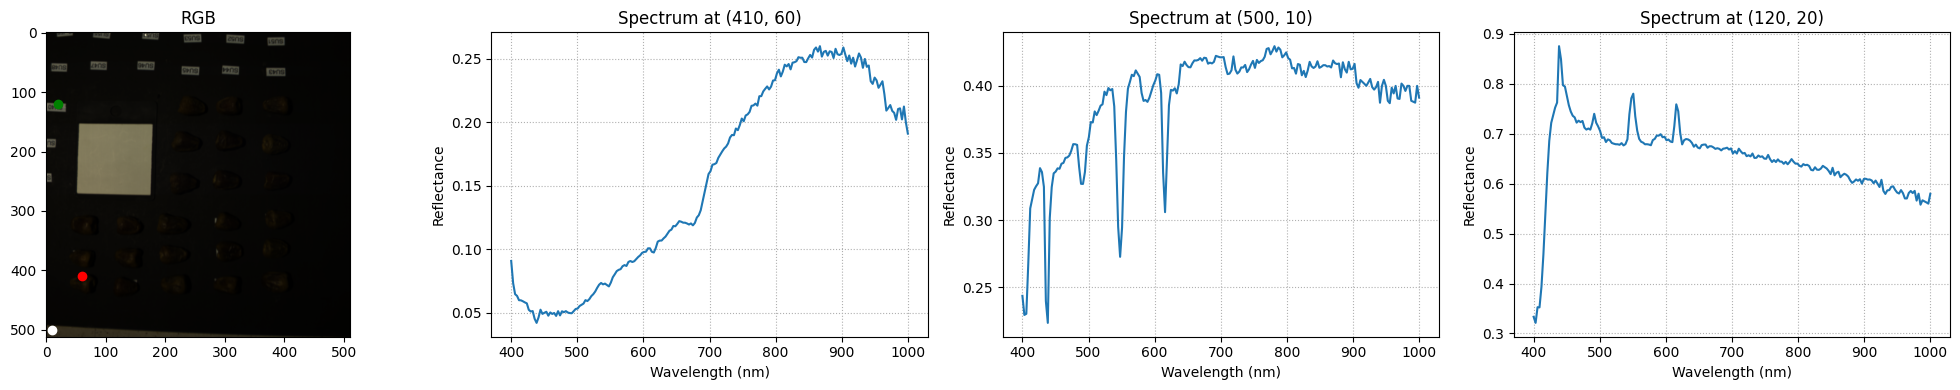

0.2600473
158
0.42956927
44
0.8754579
13


In [ ]:
plt.figure(figsize=(20, 4))

pos = [ 410,60, # Date
        500,10, # Floor
        120,20 # Label
]


# plot RGB 
plt.subplot(1, 4, 1)
plt.imshow(spec.get_rgb(example_HS))
plt.title('RGB')
# plot a dot on the RGB image at the point location
plt.plot(pos[1], pos[0], 'ro')
plt.plot(pos[3], pos[2], 'wo')
plt.plot(pos[5], pos[4], 'go')

for i in range (3):
    # Plot spectra 
    y, x = pos[2 * i], pos[2 * i + 1]
    plt.subplot(1, 4, i + 2)
    plt.plot(wave, example_HS[y, x, :].squeeze())
    plt.title(f'Spectrum at ({y}, {x})')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True, linestyle=':')
    plt.tight_layout()
plt.tight_layout()

plt.show()

# Findinig the maximum and minimum value of the reflactance for the mask (since it finds a wavelenght, the values found should be fine for all the images)
print(example_HS[pos[0], pos[1], :].squeeze().max())
i_max = np.argmax(example_HS[pos[0], pos[1], :])
print(i_max)

print(example_HS[pos[2], pos[3], :].squeeze().max())
f_max = np.argmax(example_HS[pos[2], pos[3], :50])
print(f_max)

print(example_HS[pos[4], pos[5], :].squeeze().max())
l_max = np.argmax(example_HS[pos[4], pos[5], :50])
print(l_max)




## Converting data to numpy arrays

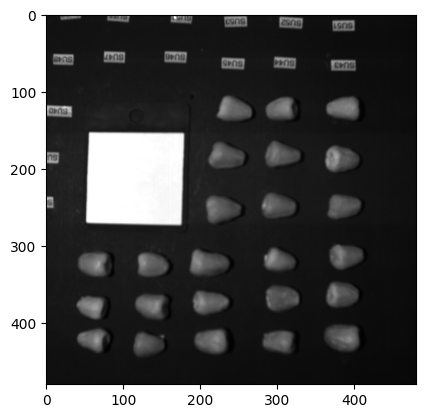

In [5]:
HS_array = []
for i in range(len(HS_res_files)):
    loaded = HS_res_files[i].load()
    HS_array.append(255*np.array(loaded[:480,:480]))
del loaded, HS_res_files# optimize memory usage
plt.imshow((HS_array[1][:,:,i_max]),cmap='gray',vmin=0, vmax=255)

## Simple Thresholding compared with Otsu Binaryzation

### Creating and applying the masks

In [6]:
# A mask should be created for not more than 3 photos, since for each group of dates we do 3 photos corrisponding to a rotation of 120 degree each.
# To avoid any misalignement errors we will do a mask for each photo

imgfiltered = []
for v in range(3): # 3 variations

    for p in range(3): # 3 photos for each variation

        for r in range(3): # 3 rotations
            
            ret,white_mask= cv.threshold(HS_array[9*v + 3*p +  r][:480,:480,f_max],60,255,cv.THRESH_BINARY) # Only the white reference and the floor are selected, manual tuning of the threshould may be required.
            ret,label_mask= cv.threshold(HS_array[9*v + 3*p +  r][:480,:480,l_max],80,255,cv.THRESH_BINARY) # Mask used to highlight the labels
            mask = np.maximum(white_mask,label_mask ) # Merging the two masks

            mask = mask > 254

            mask = binary_opening(mask, structure=np.ones((3, 3)), iterations=2) # Trying to fill some small holes that can appear
            mask = binary_dilation(mask, structure=np.ones((1, 1)), iterations=1) # Slightly expand the mask to fill holes and avoi artifacts
            #mask = binary_opening(mask, structure=np.ones((3, 3)), iterations=5) # Trying to fill some small holes that can appear


            mask = mask[:,:,None] # Broadcasting mask in 3D
            img = HS_array[9*v + 3*p +  r].copy()
            filtered = np.where(mask, 0, img) 
            imgfiltered.append(  np.where(filtered- 50 > 0,(255/np.max(filtered)) * filtered, 0)) # The black cardboard has a reflactance of approximatly 0.1, so in this way we set its value to 0
            
del white_mask,label_mask,mask, img, filtered

### Result

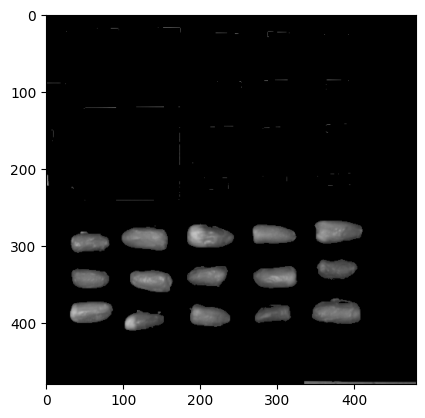

In [7]:
plt.imshow((imgfiltered[-2][:,:,i_max]),cmap='gray',vmin=0, vmax=255)

### Apply binarization

In [ ]:

height, width, wavs = imgfiltered[0].shape
final = np.zeros((height, width,wavs), dtype=np.uint8)  # Array 3D
binary = np.zeros((height, width,wavs), dtype=np.uint8)  # Array 3D
bn = []
out = [] # Output using Otsu binarization

for v in range(3): # 3 variations

    for p in range(3): # 3 photos for each variation

        for r in range(3): # 3 Rotations done

            for w in range(wavs): 

                ret2,final[:,:,w] = cv.threshold(imgfiltered[9*v+ 3*p + r][:,:,w].astype(np.uint8),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
                ret2,binary[:,:,w] = cv.threshold(imgfiltered[9*v+ 3*p + r][:,:,w].astype(np.uint8),0,255,cv.THRESH_BINARY)

            out.append(final.copy())
            bn.append(binary.copy())
del final, binary

### Plotting

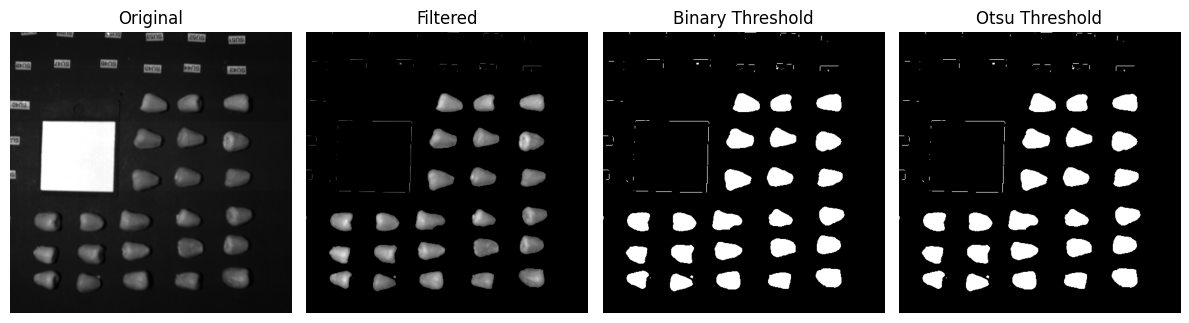

In [9]:
# Create list of images to display
image = 1
images = [
    HS_array[image][:,:,i_max],
    imgfiltered[image][:,:,i_max],  # First band of hyperspectral data
    bn[image][:,:,i_max],
    out[image][:,:,i_max]            # Otsu threshold result
]
titles = ["Original", "Filtered", "Binary Threshold", "Otsu Threshold"]
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axs[i].imshow(images[i], cmap='gray',vmin=0, vmax=255)
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Data extraction

## Labelling

### Labelling function

In [10]:
from skimage.measure import label, regionprops

def ext_label(data,i_max):
# Labelling 
    label_image = label(data[:, :, i_max])
    regions = regionprops(label_image) # Group each date into a region
    min_area = 600  
    valid_regions = [r for r in regions if r.area >= min_area]
    # Area adjustments
    y_min = min([r.centroid[0] for r in valid_regions])
    heights = [( r.bbox[2] - r.bbox[0]) for r in valid_regions]
    widths = [(r.bbox[3] - r.bbox[1]) for r in valid_regions]
    
    row_height = np.mean(heights) #  Used to approximate the size of a row, in this way dates that are in the same row will have the same Y coordinate
    col_width = np.mean(widths)  # Used to approximate the size of a column, in this way dates that are in the same col#umn will have the same X coordinate
    valid_regions = sorted(valid_regions,
                        key=lambda r: (
                            np.floor((r.centroid[0] - y_min)/  (row_height ** 1.02)),
                            np.floor((r.centroid[1])/ (col_width**1.02))
                        ))
    return valid_regions

### Plotting

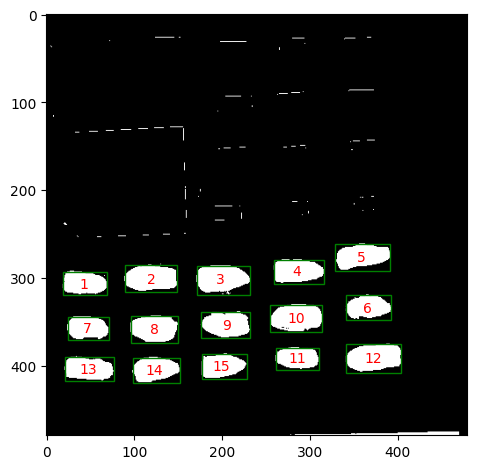

In [11]:
# Dates labelling 
photo =    -1   

valid_regions = ext_label(out[photo],i_max)

# Plotting
fig, ax = plt.subplots()
ax.imshow(out[photo][:,:,i_max], cmap='gray')

for idx, r in enumerate(valid_regions):
    y, x = r.centroid # Find the center of the region
    ax.text(x, y, idx+1, color='red', fontsize=10, ha='center', va='center')
    # Draw bounding box
    minr, minc, maxr, maxc = r.bbox
    rect = plt.Rectangle((minc, minr), maxc-minc, maxr-minr,
                         fill=False, edgecolor='green', linewidth=1)
    ax.add_patch(rect)
plt.tight_layout()
plt.show()

### Plotting a single date

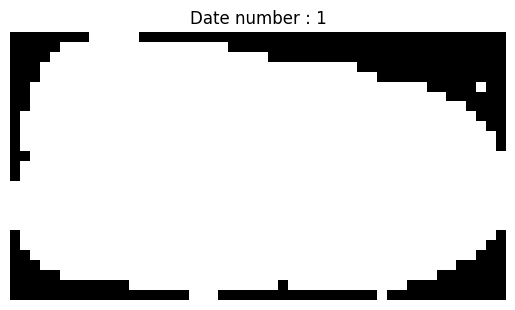

In [12]:
target_index = 1
target_region = valid_regions[target_index-1] # Selecting the date

# Extraction of coordinates
minr, minc, maxr, maxc = target_region.bbox

# Plot
plt.figure()
plt.imshow(out[photo][minr:maxr, minc:maxc, i_max], cmap='gray')
plt.title("Date number : {}".format(target_index))
plt.axis('off')
plt.show()

## Mean values and standard deviations

### Data extraction

In [ ]:
date = [] # This will be the array with all the data 

for a in range (3): # Consider every varieties    

    variety = [] # This array will contain data related to dates belonging to the same variety
    for v in range(3): # Consider all the dates of the same variety

        rotation_set = [] # This array will contain data related to dates belonging to the same variavarietytion and the same scenario

        for r in range(3): # Consider the same scenario but with a rotation of 120 degrees

            photo =   9*a + 3*v + r # Index of the photo
            # Labelling 
            valid_regions = ext_label(out[photo],i_max)
            spectra = [] # This array will contain data related to dates belonging to the same variety and the same photo
            for d in range(len(valid_regions)): # Select each date in a photo

                target_region = valid_regions[d]

                minr, minc, maxr, maxc = target_region.bbox
                # Compute the mean spectra of a single date
                spectrum = np.mean(HS_array[photo][minr:maxr, minc:maxc, :]/255, axis=(0, 1))
                spectra.append(spectrum)
            rotation_set.append(spectra)
        variety.append(rotation_set)
    date.append(variety)
    
del spectrum,spectra, rotation_set

### Mean values and standard deviations computation

In [14]:
rot_mean = []
rot_std = []
v_mean = []
v_std = []

for a in range (3): # Consider every varieties    
    # Temporary lists
    rm = []
    rs =[]
    for v in range(3): # Consider the photos of dates belonging to the same variety

        for d in range(len(date[a][v][0])): # Considering all the dates in a photo with different rotations
            avg = np.mean([date[a][v][rot][d] for rot in range(3)],axis = 0)            
            std = np.sqrt(np.mean([(date[a][v][rot][d]-avg)**2 for rot in range(3)],axis = 0))
            rm.append(avg) # Mean value for a single date done across all its 3 rotations
            rs.append(std) # Variance for a single date done across all its 3 rotations
    rot_mean.append(rm)
    rot_std.append(rs)
    
    avg = np.mean([rot_mean[a][date] for date in range(len(rot_mean[a]))],axis = 0)
    std = np.sqrt(np.mean([(rot_mean[a][date]-avg)**2 for date in range(len(rot_mean[a]))],axis = 0))
    v_mean.append(avg) # Mean value of a single variety
    v_std.append(std) # Variance of a single variety
total_mean = np.mean([v_mean[var] for var in range(3)],axis = 0)
total_std = np.sqrt(np.mean([(v_mean[var]-total_mean)**2 for var in range(3)],axis = 0)) # Maybe do the std across all the dates


### Plotting

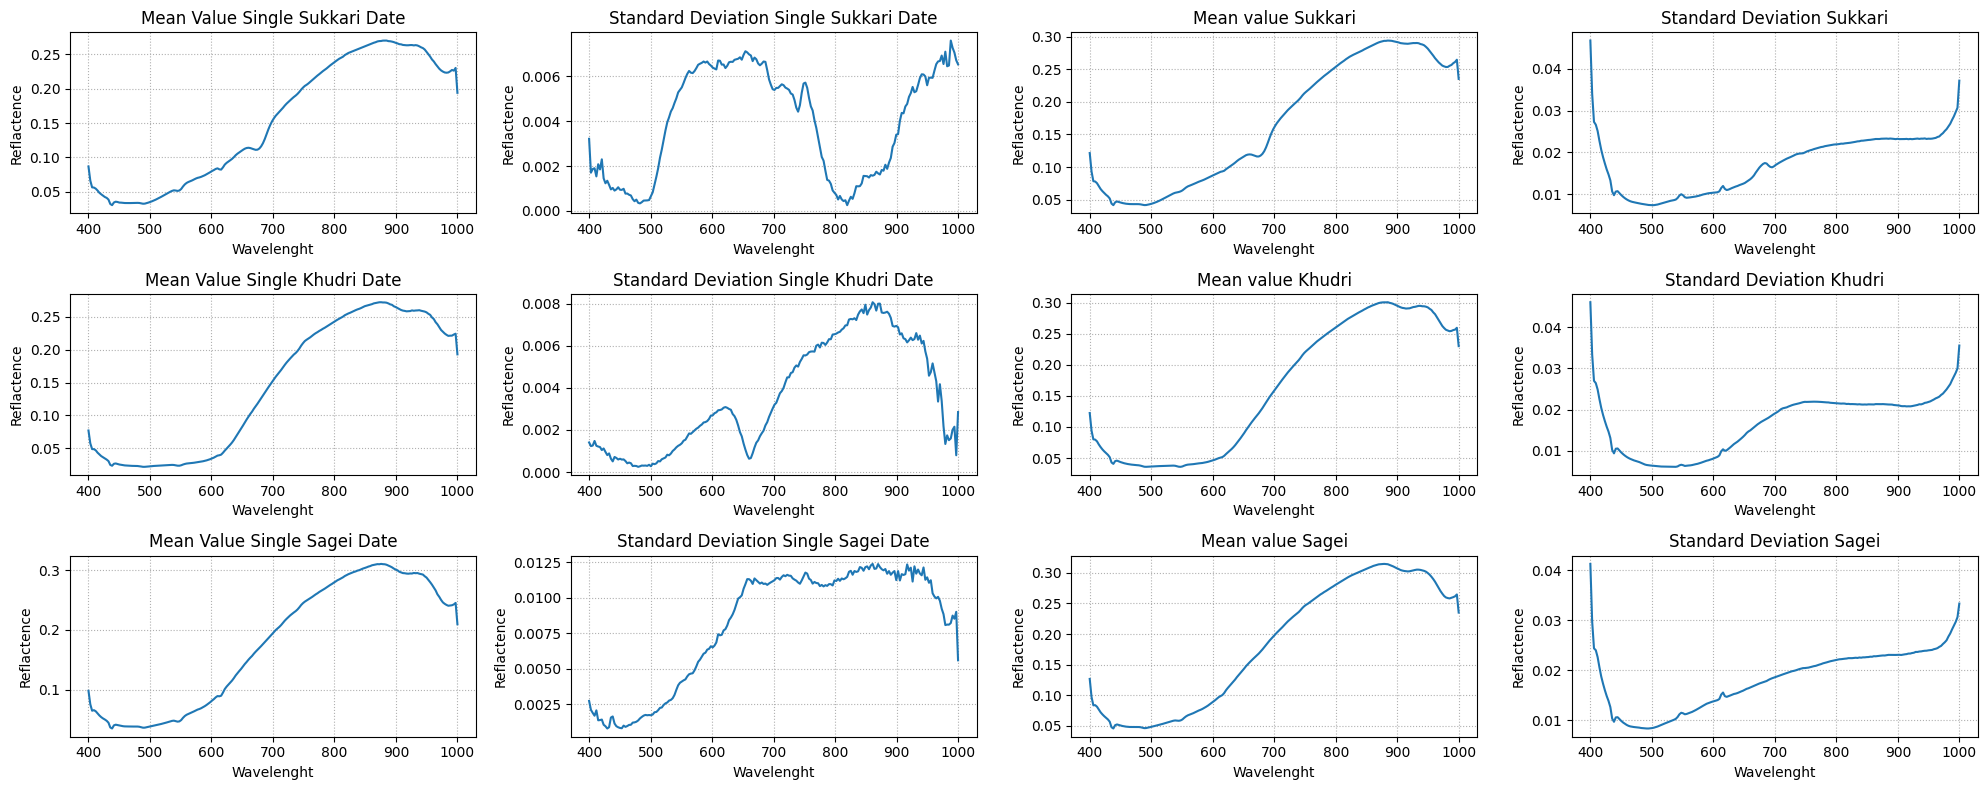

In [15]:
d = -1 # Date
images = [
    item
    for a in range(3)
    for item in [rot_mean[a][d], rot_std[a][d], v_mean[a], v_std[a]]
]

titles = ["Mean Value Single Sukkari Date", "Standard Deviation Single Sukkari Date", "Mean value Sukkari","Standard Deviation Sukkari",
          "Mean Value Single Khudri Date", "Standard Deviation Single Khudri Date", "Mean value Khudri","Standard Deviation Khudri",
          "Mean Value Single Sagei Date", "Standard Deviation Single Sagei Date", "Mean value Sagei","Standard Deviation Sagei",]

fig, axs = plt.subplots(3, 4, figsize=(20, 8))  # aumenta un po' l'altezza

for idx, ax in enumerate(axs.flat):  
    ax.plot(wave, images[idx])
    ax.set_title(titles[idx])
    ax.grid(True, linestyle=':')
    ax.set_xlabel("Wavelenght")
    ax.set_ylabel("Reflactence")

plt.tight_layout()
plt.show()

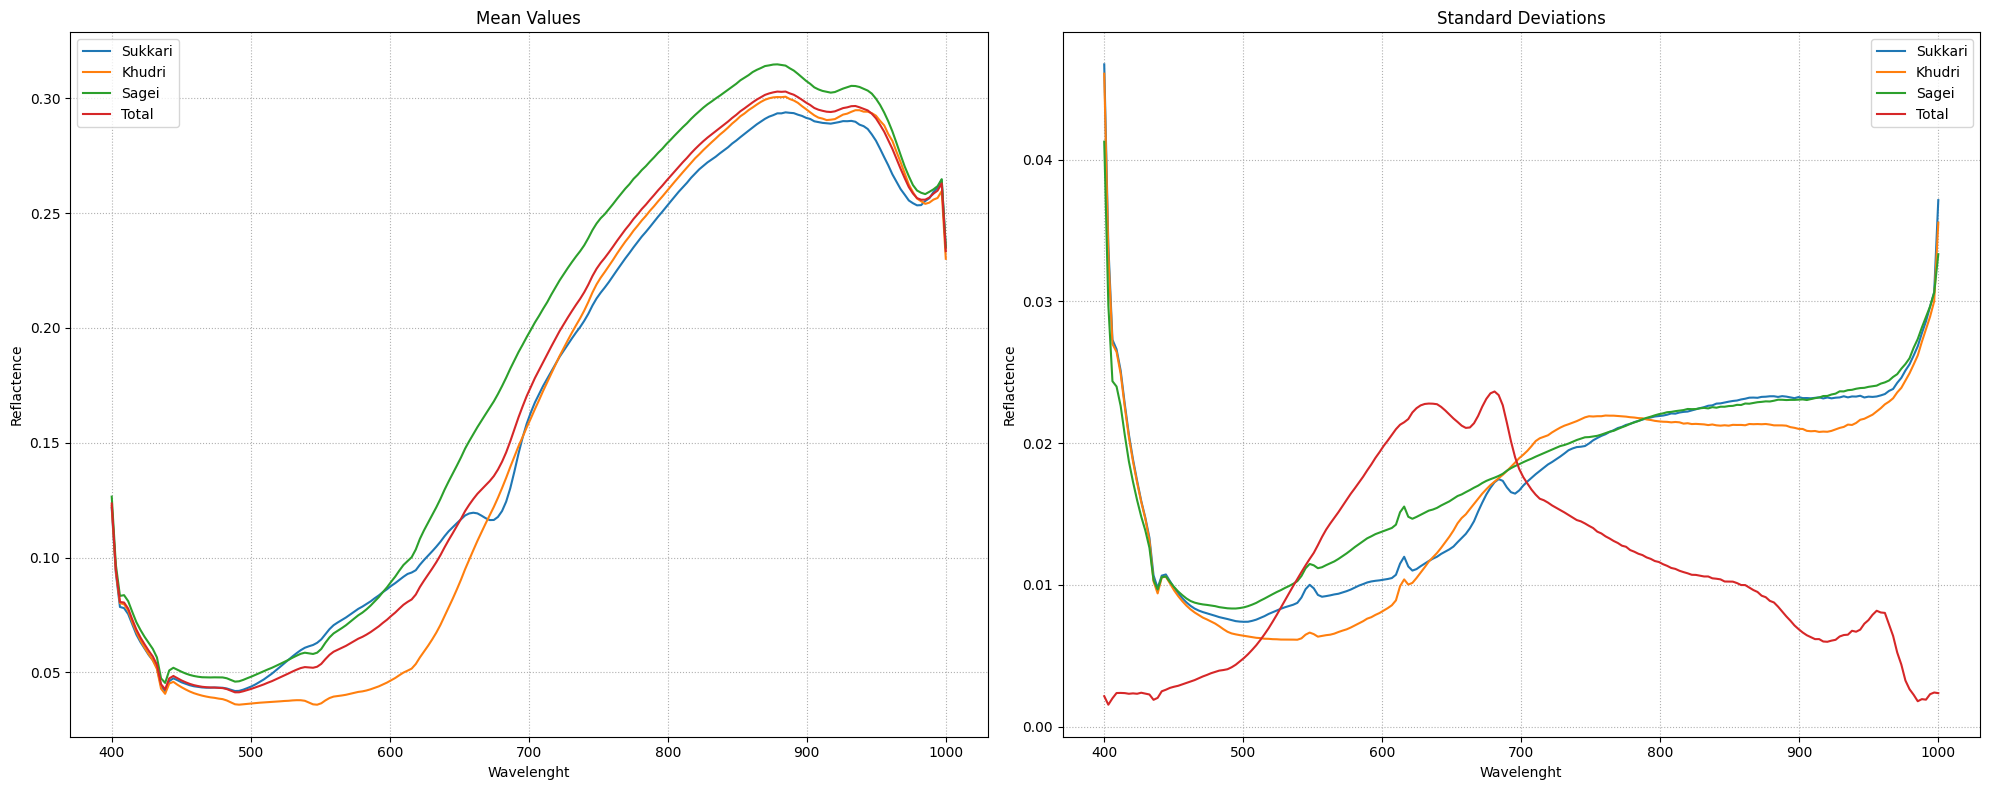

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # aumenta un po' l'altezza
labels = ["Sukkari", "Khudri", "Sagei"]

for i, label in enumerate(labels):
    axs[0].plot(wave, images[4*i+2], label=label)
    axs[1].plot(wave, images[4*i+3], label=label)

axs[0].plot(wave, total_mean, label="Total")
axs[1].plot(wave, total_std, label="Total")


axs[0].set_title("Mean Values")
axs[0].set_xlabel("Wavelenght")
axs[0].set_ylabel("Reflactence")

axs[0].grid(True, linestyle=':')
axs[0].legend()

axs[1].set_title("Standard Deviations")
axs[1].set_xlabel("Wavelenght")
axs[1].set_ylabel("Reflactence")
axs[1].grid(True, linestyle=':')
axs[1].legend()

plt.tight_layout()
plt.show()
